In [1]:
import tqdm
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset

In [2]:
base_path = 'classification_data'
train_path = os.path.join(base_path, 'train_data')  
val_path = os.path.join(base_path, 'val_data')  
test_path = os.path.join(base_path, 'test_data') # Not used yet

In [3]:

class FaceDataset(Dataset):
    def __init__(self, root, transform=None, load_all=False):
        self.root = root
        self.transform = transform
        self.unique_label_ids = os.listdir(self.root)
        print("Unique labels", len(self.unique_label_ids))
        
        self.image_paths = []
        self.label_nums = []
        self.label_ids = []
        self.num_classes = len(self.unique_label_ids) 
        self.unique_label_nums = list(range(self.num_classes))
        
        # Iterate over each folder, which contains the images
        # from a same ID (a same person).
        for label_num, label_id in enumerate(self.unique_label_ids):
            folder_path = os.path.join(self.root, label_id)
            
            # Input list
            images_list = os.listdir(folder_path)
            images_list_abs = [os.path.join(folder_path, image_path) for image_path in images_list]
            self.image_paths += images_list_abs
            
            # Labels list
            num_images = len(images_list)
            image_label_ids = [label_id] * num_images
            self.label_ids += image_label_ids
            
            # We need the index of the label
            image_label_nums = [label_num] * num_images
            self.label_nums += image_label_nums
            
        assert len(self.image_paths) == len(self.label_nums)
        
        self.data_len = len(self.label_nums)
        print("Total samples:", self.data_len)
        self.images = dict()
        if load_all:
            print("Loading all images...")
            for i in tqdm.notebook.tqdm(range(self.data_len)):
                self.images[i] = self.__load_image(i)
                
    def __load_image(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path).convert('RGB')  # Ensure images are in RGB format
        if self.transform:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        """ Lazy load image"""
        try:
            x = self.images[index]
        except KeyError:
            x = self.__load_image(index)
        return x, self.label_nums[index]
    
    def reduce_samples(self, ids):
        current_len = self.data_len
        new_image_paths = []
        new_label_nums = []
        new_label_ids = []
        
        for i in range(current_len):
            label_id = self.label_ids[i]
            image_path = self.image_paths[i]
            
            if label_id in ids:
                new_label_ids.append(label_id)
                new_image_paths.append(image_path)
                new_label_nums.append(ids.index(label_id)) 
        
        # Update Labels
        self.label_ids = new_label_ids
        self.label_nums = new_label_nums
        self.unique_label_ids = ids
        self.num_classes = len(self.unique_label_ids)
        self.unique_label_nums = list(range(self.num_classes))
        
        # Update Input
        self.image_paths = new_image_paths
        self.images = dict()  # Reset lazy loading
        
        self.data_len = len(new_label_ids)
        
        print("Before", current_len)
        print("After", self.data_len)
        print("Label nums", len(self.label_nums))
        print("New Unique labels", self.num_classes, self.unique_label_nums)


In [4]:
params = dict(
    epochs=20,
    batch_size=128,
    num_labels=500,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer_params=dict(
        lr=0.1,
    )
)
IN_CHANNELS = 3


In [5]:

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:

print("Training Data")
train_dataset = FaceDataset(train_path, transform=transform)
labels = train_dataset.unique_label_ids[:params['num_labels']]
train_dataset.reduce_samples(labels)
print()
print("Validation Data")
val_dataset = FaceDataset(val_path, transform=transform)
val_dataset.reduce_samples(labels)

train_loader_args = dict(shuffle=True,
                        batch_size=params['batch_size'],               
                        )
train_loader = data.DataLoader(train_dataset, **train_loader_args)
val_loader = data.DataLoader(val_dataset, **train_loader_args)
NUM_CLASSES = train_dataset.num_classes  

Training Data
Unique labels 4000
Total samples: 380638
Before 380638
After 48187
Label nums 48187
New Unique labels 500 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,

In [7]:

# === Extension: model, training loops, progress bars, and evaluation ===
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [8]:

# 1. Backbone and classifier definitions
class FaceBackbone(nn.Module):
    def __init__(self, in_ch=IN_CHANNELS):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
        )
    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)

class FaceClassifier(nn.Module):
    def __init__(self, num_classes, embed_dim=128):
        super().__init__()
        self.backbone = FaceBackbone()
        self.embed_head = nn.Sequential(
            nn.Linear(128, embed_dim),
            nn.BatchNorm1d(embed_dim), nn.ReLU(),
        )
        self.classify_head = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        feats = self.backbone(x)
        embeds = self.embed_head(feats)
        logits = self.classify_head(embeds)
        return logits, F.normalize(embeds, dim=1)


In [11]:

# 2. Classification training with progress bar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf_model = FaceClassifier(NUM_CLASSES).to(device)
optimizer = optim.SGD(clf_model.parameters(), **params['optimizer_params'], momentum=0.9)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for ep in range(params['epochs']):
    # training
    clf_model.train()
    loader = tqdm.tqdm(train_loader, desc=f"Cls Train Ep{ep+1}/{params['epochs']}", leave=False)
    t_loss = t_acc = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits, _ = clf_model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        batch_acc = (logits.argmax(1)==labels).float().mean().item()
        loader.set_postfix(loss=f"{loss.item():.3f}", acc=f"{batch_acc:.3f}")
        t_loss += loss.item()*imgs.size(0)
        t_acc  += (logits.argmax(1)==labels).sum().item()
    # validation
    clf_model.eval()
    v_loss = v_acc = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = clf_model(imgs)
            loss = criterion(logits, labels)
            v_loss += loss.item()*imgs.size(0)
            v_acc  += (logits.argmax(1)==labels).sum().item()
    trl = t_loss/len(train_loader.dataset)
    tra = t_acc/len(train_loader.dataset)
    vl = v_loss/len(val_loader.dataset)
    va = v_acc/len(val_loader.dataset)
    history['train_loss'].append(trl)
    history['train_acc'].append(tra)
    history['val_loss'].append(vl)
    history['val_acc'].append(va)
    print(f"[Epoch {ep+1}] Train Loss: {trl:.4f}, Acc: {tra:.4f}")
    print(f"[Epoch {ep+1}] Val Loss: {vl:.4f}, Acc: {va:.4f}")

[Epoch 1] Train Loss: 5.9895, Acc: 0.0104
[Epoch 1] Val Loss: 6.3050, Acc: 0.0090


[Epoch 2] Train Loss: 5.4434, Acc: 0.0294
[Epoch 2] Val Loss: 5.7940, Acc: 0.0120


[Epoch 3] Train Loss: 5.0021, Acc: 0.0543
[Epoch 3] Val Loss: 5.3015, Acc: 0.0460


[Epoch 4] Train Loss: 4.5938, Acc: 0.0905
[Epoch 4] Val Loss: 5.1172, Acc: 0.0490


[Epoch 5] Train Loss: 4.1576, Acc: 0.1453
[Epoch 5] Val Loss: 4.4634, Acc: 0.1090


[Epoch 6] Train Loss: 3.7444, Acc: 0.2046
[Epoch 6] Val Loss: 4.3163, Acc: 0.1490


[Epoch 7] Train Loss: 3.3872, Acc: 0.2605
[Epoch 7] Val Loss: 4.3714, Acc: 0.1610


[Epoch 8] Train Loss: 3.0682, Acc: 0.3142
[Epoch 8] Val Loss: 4.0988, Acc: 0.2100


[Epoch 9] Train Loss: 2.8082, Acc: 0.3636
[Epoch 9] Val Loss: 3.5205, Acc: 0.2340


[Epoch 10] Train Loss: 2.5920, Acc: 0.4017
[Epoch 10] Val Loss: 3.5911, Acc: 0.2750


[Epoch 11] Train Loss: 2.4043, Acc: 0.4383
[Epoch 11] Val Loss: 3.4191, Acc: 0.2760


[Epoch 12] Train Loss: 2.2514, Acc: 0.4683
[Epoch 12] Val Loss: 3.4953, Acc: 0.2700


[Epoch 13] Train Loss: 2.1149, Acc: 0.4957
[Epoch 13] Val Loss: 3.4757, Acc: 0.2860


[Epoch 14] Train Loss: 1.9995, Acc: 0.5194
[Epoch 14] Val Loss: 3.5511, Acc: 0.3020


[Epoch 15] Train Loss: 1.8863, Acc: 0.5394
[Epoch 15] Val Loss: 3.1323, Acc: 0.3580


[Epoch 16] Train Loss: 1.7892, Acc: 0.5597
[Epoch 16] Val Loss: 3.3748, Acc: 0.3350


[Epoch 17] Train Loss: 1.7034, Acc: 0.5777
[Epoch 17] Val Loss: 3.1753, Acc: 0.3610


[Epoch 18] Train Loss: 1.6173, Acc: 0.5960
[Epoch 18] Val Loss: 3.3771, Acc: 0.3250


[Epoch 19] Train Loss: 1.5471, Acc: 0.6096
[Epoch 19] Val Loss: 3.6244, Acc: 0.3250


[Epoch 20] Train Loss: 1.4748, Acc: 0.6256
[Epoch 20] Val Loss: 3.4600, Acc: 0.3410


In [12]:
# After classification training
torch.save(clf_model.state_dict(), 'clf_model1.pth')

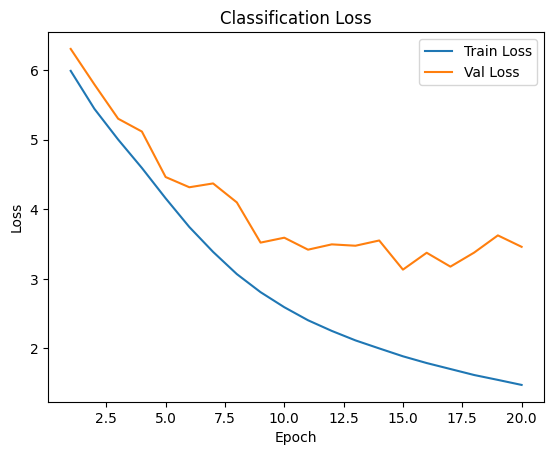

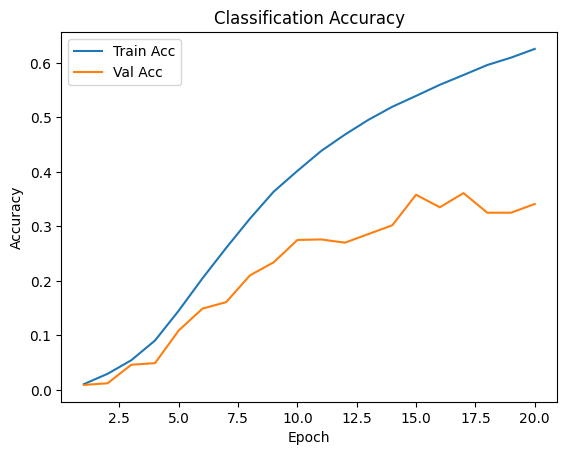

In [13]:

# plot classification metrics
epochs = range(1, params['epochs']+1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Classification Loss'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Classification Accuracy'); plt.legend(); plt.show()


In [15]:

# 3. Triplet training with progress bar
class TripletDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        from collections import defaultdict
        self.label2idx = defaultdict(list)
        for i, l in enumerate(ds.label_nums): self.label2idx[l].append(i)
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        a_img, a_lbl = self.ds[idx]
        pos = idx
        while pos == idx:
            pos = np.random.choice(self.label2idx[a_lbl])
        neg_lbl = a_lbl
        while neg_lbl == a_lbl:
            neg_lbl = np.random.choice(list(self.label2idx.keys()))
        neg = np.random.choice(self.label2idx[neg_lbl])
        p_img, _ = self.ds[pos]
        n_img, _ = self.ds[neg]
        return a_img, p_img, n_img

trip_ds = TripletDataset(train_dataset)
trip_loader = data.DataLoader(trip_ds, batch_size=params['batch_size'], shuffle=True)
trip_model = nn.Sequential(clf_model.backbone, clf_model.embed_head).to(device)
trip_opt   = optim.Adam(trip_model.parameters(), lr=1e-3)
trip_crit  = nn.TripletMarginLoss(margin=1.0)

triplet_loss_history = []

for ep in range(params['epochs']):
    loader = tqdm.tqdm(trip_loader, desc=f"Trip Ep{ep+1}/{params['epochs']}", leave=False)
    total = 0
    for a, p, n in loader:
        a, p, n = a.to(device), p.to(device), n.to(device)
        ea, epos, eneg = trip_model(a), trip_model(p), trip_model(n)
        loss = trip_crit(ea, epos, eneg)
        trip_opt.zero_grad()
        loss.backward()
        trip_opt.step()
        loader.set_postfix(loss=f"{loss.item():.3f}")
        total += loss.item() * a.size(0)

    epoch_loss = total / len(trip_loader.dataset)
    triplet_loss_history.append(epoch_loss)
    print(f"[Triplet Epoch {ep+1}] Loss {epoch_loss:.4f}")

[Triplet Epoch 1] Loss 0.2673


[Triplet Epoch 2] Loss 0.2485


[Triplet Epoch 3] Loss 0.2368


[Triplet Epoch 4] Loss 0.2289


[Triplet Epoch 5] Loss 0.2329


[Triplet Epoch 6] Loss 0.2228


[Triplet Epoch 7] Loss 0.2201


[Triplet Epoch 8] Loss 0.2121


[Triplet Epoch 9] Loss 0.2115


[Triplet Epoch 10] Loss 0.2061


[Triplet Epoch 11] Loss 0.2081


[Triplet Epoch 12] Loss 0.2033


[Triplet Epoch 13] Loss 0.2048


[Triplet Epoch 14] Loss 0.1994


[Triplet Epoch 15] Loss 0.1982


[Triplet Epoch 16] Loss 0.1982


[Triplet Epoch 17] Loss 0.1938


[Triplet Epoch 18] Loss 0.1946


[Triplet Epoch 19] Loss 0.1910


[Triplet Epoch 20] Loss 0.1889


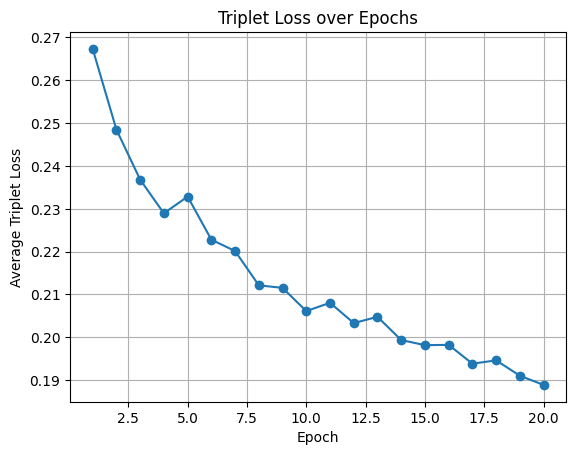

In [16]:
# 2. after training, plot it
import matplotlib.pyplot as plt

epochs = list(range(1, params['epochs'] + 1))
plt.figure()
plt.plot(epochs, triplet_loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Triplet Loss')
plt.title('Triplet Loss over Epochs')
plt.grid(True)
plt.show()

In [17]:
# After triplet‐loss training
torch.save(trip_model.state_dict(), 'triplet_model1.pth')

100%|██████████| 8805/8805 [00:15<00:00, 574.30it/s]


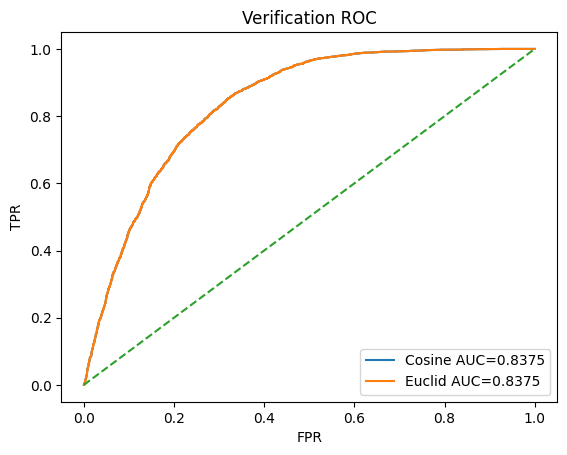

In [50]:

# 4. Verification ROC & AUC
pairs = pd.read_csv('verification_pairs_val.txt', sep=' ', header=None, names=['img1','img2','label']).astype({'label':'int'})
cos_s, euc_s, lbls = [], [], []
for _, r in tqdm.tqdm(pairs.iterrows(), total=len(pairs)):
    def get_emb1(p):
        img = transform(Image.open(p).convert('RGB')).unsqueeze(0).to(device)
        with torch.no_grad(): _, emb = clf_model(img)
        return emb.cpu().numpy()[0]
    e1, e2 = get_emb1(r.img1), get_emb1(r.img2)
    cos_s.append(np.dot(e1, e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)))
    euc_s.append(-np.linalg.norm(e1 - e2))
    lbls.append(r.label)
    
fpr_c, tpr_c, _ = roc_curve(lbls, cos_s)
auc_c = auc(fpr_c, tpr_c)
fpr_e, tpr_e, _ = roc_curve(lbls, euc_s)
auc_e = auc(fpr_e, tpr_e)
plt.figure()
plt.plot(fpr_c, tpr_c, label=f"Cosine AUC={auc_c:.4f}")
plt.plot(fpr_e, tpr_e, label=f"Euclid AUC={auc_e:.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Verification ROC'); plt.legend(); plt.show()


In [51]:
# 3.3 Similarity Distributions
# (we negated Euclid above, so invert back for actual distances)
positive_cos = [s for s, y in zip(cos_s, lbls) if y==1]
negative_cos = [s for s, y in zip(cos_s, lbls) if y==0]
positive_euc = [-s for s, y in zip(euc_s, lbls) if y==1]
negative_euc = [-s for s, y in zip(euc_s, lbls) if y==0]

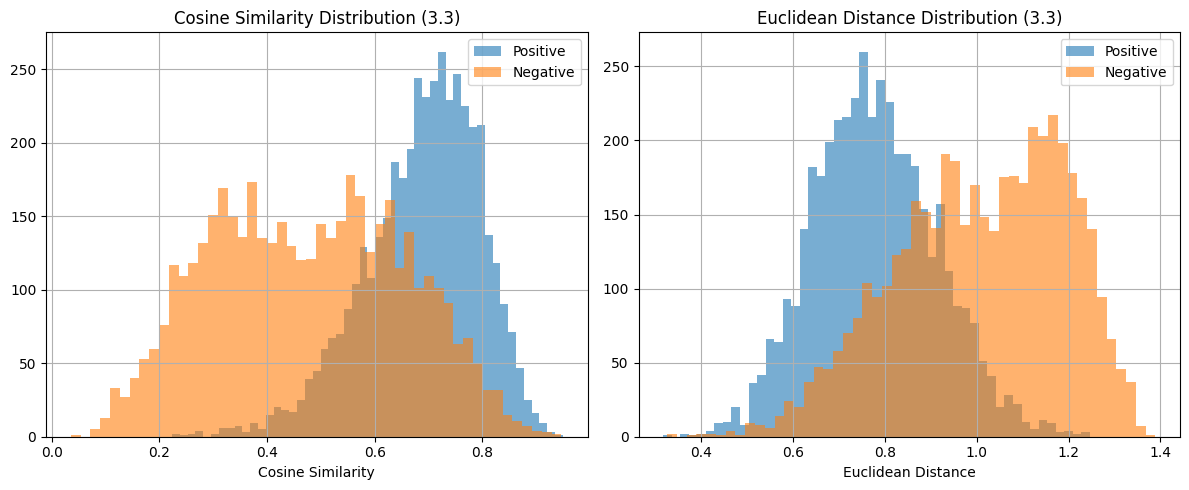

In [53]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(positive_cos, bins=50, alpha=0.6, label='Positive')
plt.hist(negative_cos, bins=50, alpha=0.6, label='Negative')
plt.title('Cosine Similarity Distribution (3.3)')
plt.xlabel('Cosine Similarity')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(positive_euc, bins=50, alpha=0.6, label='Positive')
plt.hist(negative_euc, bins=50, alpha=0.6, label='Negative')
plt.title('Euclidean Distance Distribution (3.3)')
plt.xlabel('Euclidean Distance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

100%|██████████| 8805/8805 [00:13<00:00, 634.99it/s]


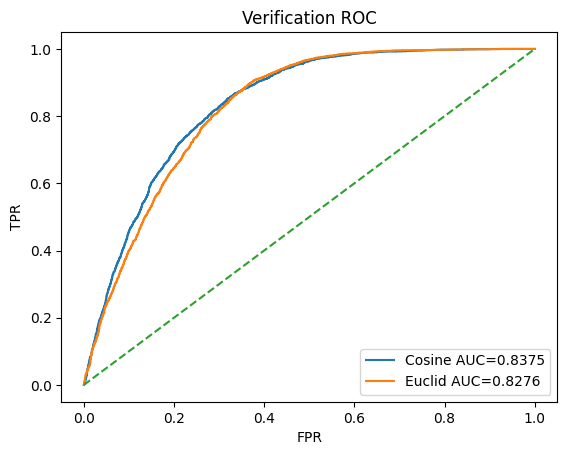

In [54]:

# 4. Verification ROC & AUC
pairs = pd.read_csv('verification_pairs_val.txt', sep=' ', header=None, names=['img1','img2','label']).astype({'label':'int'})
cos_s1, euc_s1, lbls1 = [], [], []
for _, r in tqdm.tqdm(pairs.iterrows(), total=len(pairs)):
    def get_emb(p):
        img = transform(Image.open(p).convert('RGB')).unsqueeze(0).to(device)
        with torch.no_grad():  emb = trip_model(img)
        return emb.cpu().numpy()[0]
    e3, e4 = get_emb(r.img1), get_emb(r.img2)
    cos_s1.append(np.dot(e3, e4)/(np.linalg.norm(e3)*np.linalg.norm(e4)))
    euc_s1.append(-np.linalg.norm(e3 - e4))
    lbls1.append(r.label)
    
fpr_c1, tpr_c1, _ = roc_curve(lbls1, cos_s1)
auc_c1 = auc(fpr_c1, tpr_c1)
fpr_e1, tpr_e1, _ = roc_curve(lbls1, euc_s1)
auc_e1 = auc(fpr_e1, tpr_e1)
plt.figure()
plt.plot(fpr_c1, tpr_c1, label=f"Cosine AUC={auc_c1:.4f}")
plt.plot(fpr_e1, tpr_e1, label=f"Euclid AUC={auc_e1:.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Verification ROC'); plt.legend(); plt.show()


In [55]:
# 3.3 Similarity Distributions
# (we negated Euclid above, so invert back for actual distances)
positive_cos1 = [s for s, y in zip(cos_s1, lbls1) if y==1]
negative_cos1 = [s for s, y in zip(cos_s1, lbls1) if y==0]
positive_euc1 = [-s for s, y in zip(euc_s, lbls1) if y==1]
negative_euc1 = [-s for s, y in zip(euc_s, lbls1) if y==0]

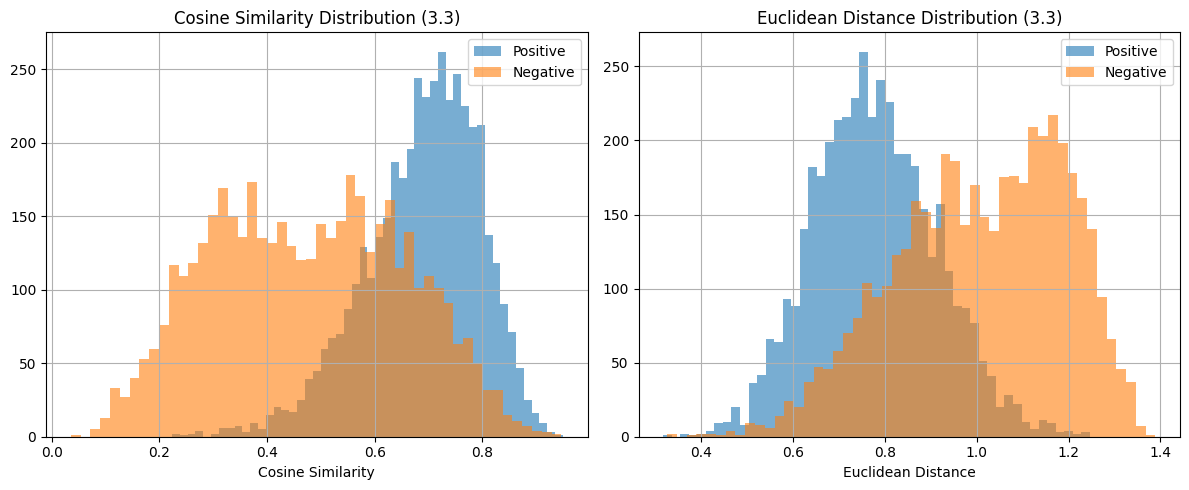

In [57]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(positive_cos1, bins=50, alpha=0.6, label='Positive')
plt.hist(negative_cos1, bins=50, alpha=0.6, label='Negative')
plt.title('Cosine Similarity Distribution (3.3)')
plt.xlabel('Cosine Similarity')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(positive_euc1, bins=50, alpha=0.6, label='Positive')
plt.hist(negative_euc1, bins=50, alpha=0.6, label='Negative')
plt.title('Euclidean Distance Distribution (3.3)')
plt.xlabel('Euclidean Distance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()